In [118]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
warnings.filterwarnings('ignore')
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
data = pd.read_csv('Taxi.4.csv', index_col=0, parse_dates=True)

In [119]:
for i in range(1, 6):
    data[f'w_s{i}']=np.sin(np.arange(1, data.shape[0]+1, 1)*2*np.pi*i/168)
    data[f'w_c{i}']=np.cos(np.arange(1, data.shape[0]+1, 1)*2*np.pi*i/168)

#### Прогнозы SARIMAX на все часы с 01.01.2016-30.06.2016

In [120]:
E=pd.read_csv('sarima.csv')

## Выборка для t+1

In [372]:
%%time
tim=1
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(j)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-1)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()
new_data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


CPU times: user 1min 49s, sys: 3.03 s, total: 1min 53s
Wall time: 1min 58s


In [373]:
data1=new_data.copy()
train_data_1=data1.loc['2016-01-02':'2016-04-30']
val_data_1=data1.loc['2016-05-01':'2016-05-31']

### В качестве регрессора будем использовать CatBoostRegressor

#### Осуществим подбор гиперпараметров по маю 2016 года

In [123]:
from catboost import CatBoostRegressor

In [124]:
from sklearn.metrics import mean_squared_error

In [125]:
from hyperopt import fmin, tpe, hp

In [126]:
#Столбцы с категориальными признаками (зона, день недели, час)
cat_features=[9,10,11]

In [186]:
def reg(params):
    cat=CatBoostRegressor(iterations=200, depth=5, **params, silent=True)
    cat.fit(train_data_1.drop(columns=['y']), train_data_1.y, cat_features)
    preds=cat.predict(val_data_1.drop(columns=['y']))
    return mean_squared_error(val_data_1.y, preds)

In [187]:
space={
    'learning_rate':hp.uniform('learning_rate', 0.1, 1)
}

In [189]:
best=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=30)

100%|██████████| 30/30 [07:20<00:00, 14.67s/trial, best loss: 1062.4901264828986]


In [190]:
print(best)

{'learning_rate': 0.4615431237704436}


### Посмотри на графике:

In [195]:
mse_train=pd.Series()
mse_test=pd.Series()
for i in np.linspace(0.1,1,16):
    cat=CatBoostRegressor(learning_rate = i, max_depth = 5, iterations = 200, silent=True)
    cat.fit(train_data_1.drop(columns=['y']), train_data_1.y, cat_features)
    preds_train=cat.predict(train_data_1.drop(columns=['y']))
    preds_test=cat.predict(val_data_1.drop(columns=['y']))
    mse_train[i]=mean_squared_error(train_data_1.y, preds_train)
    mse_test[i]=mean_squared_error(val_data_1.y, preds_test)

In [196]:
MSE=pd.concat([mse_train, mse_test], axis=1)
MSE.columns=['train', 'test']

<AxesSubplot:>

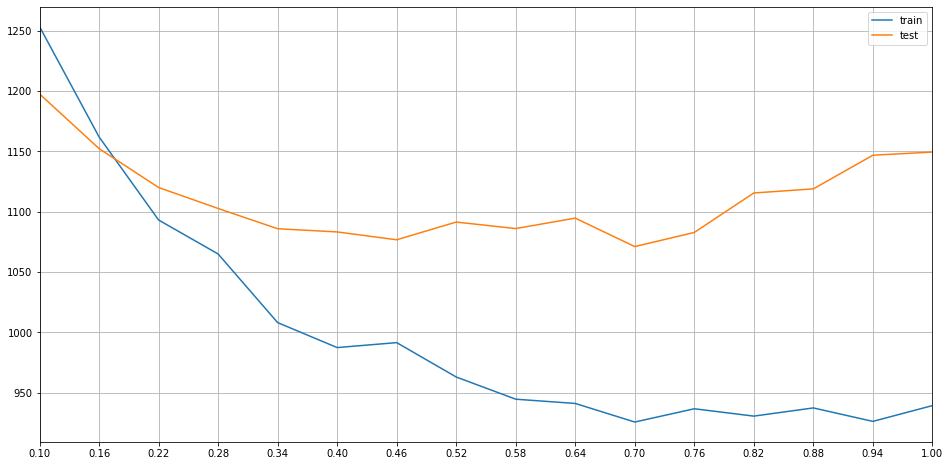

In [198]:
MSE.plot(legend=True, grid=True, figsize=(16,8), xticks=np.linspace(0.1,1,16))

In [199]:
cat1=CatBoostRegressor(**best, iterations=200, depth=5, silent=True)
cat1.fit(train_data_1.drop(columns=['y']), train_data_1.y, cat_features)
preds=cat1.predict(val_data_1.drop(columns=['y']))

In [200]:
val_data_1['preds']=preds

<AxesSubplot:>

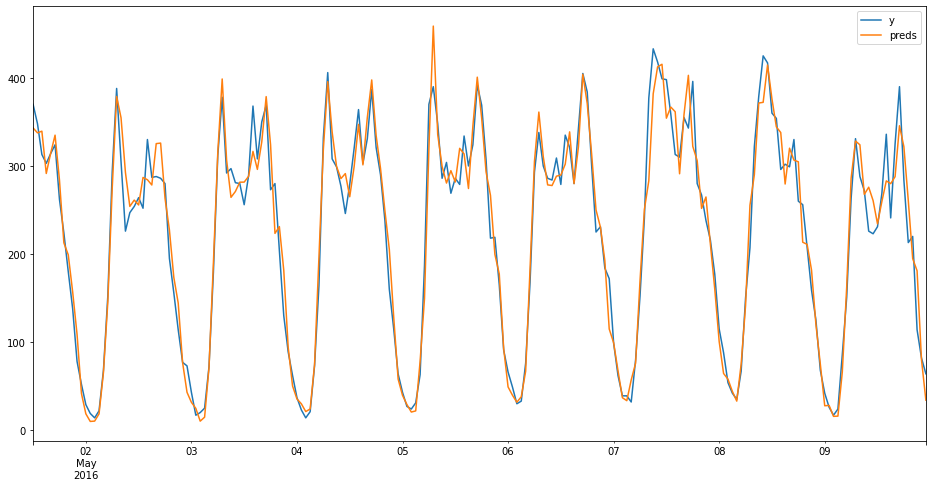

In [201]:
(val_data_1[['y', 'preds']][val_data_1.zone=='1286']).loc['2016-05-01 12:00':'2016-05-09 23:00'].plot(figsize=(16,8))

#### Невероятноя точность предсказаний на час вперед по валидационной выборке

In [210]:
train_data_1.columns[np.argsort(cat.feature_importances_)[::-1][:4]]

Index(['sar', 'trips', 'hour', 'trips_-6h'], dtype='object')

### Самые значимые признаки: Sarima, trips, hour, trips-6h

## Выборка для t+2

In [374]:
%%time
tim=2
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(j)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-2)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()
new_data.dropna(inplace=True)

CPU times: user 1min 48s, sys: 2.8 s, total: 1min 51s
Wall time: 1min 51s


In [375]:
data2=new_data.copy()
train_data_2=data2.loc['2016-01-02':'2016-04-30']
val_data_2=data2.loc['2016-05-01':'2016-05-31']

#### Осуществим подбор гиперпараметров по маю 2016 года

In [226]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_2.drop(columns=['y']), train_data_2.y, cat_features)
    preds=cat.predict(val_data_2.drop(columns=['y']))
    return mean_squared_error(val_data_2.y, preds)

In [231]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,250)
}

In [232]:
best1=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=30)

100%|██████████| 30/30 [06:18<00:00, 12.63s/trial, best loss: 1636.1217748458582]


In [233]:
print(best1)

{'depth': 6, 'iterations': 238, 'learning_rate': 0.3622177814378381}


In [234]:
cat2=CatBoostRegressor(**best1, silent=True)

## Выборка для t+3

In [376]:
%%time
tim=3
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(j)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-3)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()
new_data.dropna(inplace=True)

CPU times: user 1min 49s, sys: 2.82 s, total: 1min 52s
Wall time: 1min 51s


In [377]:
data3=new_data.copy()
train_data_3=data3.loc['2016-01-02':'2016-04-30']
val_data_3=data3.loc['2016-05-01':'2016-05-31']

#### Осуществим подбор гиперпараметров по маю 2016 года

In [263]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_3.drop(columns=['y']), train_data_3.y, cat_features)
    preds=cat.predict(val_data_3.drop(columns=['y']))
    return mean_squared_error(val_data_3.y, preds)

In [264]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,270)
}

In [265]:
best2=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=100)

100%|██████████| 100/100 [24:40<00:00, 14.81s/trial, best loss: 1980.936282831685]


In [266]:
print(best2)

{'depth': 6, 'iterations': 248, 'learning_rate': 0.4818141404128581}


In [267]:
cat3=CatBoostRegressor(**best2, silent=True)

## Выборка для t+4

In [378]:
%%time
tim=4
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(j)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-4)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()
new_data.dropna(inplace=True)

CPU times: user 1min 49s, sys: 2.72 s, total: 1min 51s
Wall time: 1min 51s


In [379]:
data4=new_data.copy()
train_data_4=data4.loc['2016-01-02':'2016-04-30']
val_data_4=data4.loc['2016-05-01':'2016-05-31']

#### Осуществим подбор гиперпараметров по маю 2016 года

In [271]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_4.drop(columns=['y']), train_data_4.y, cat_features)
    preds=cat.predict(val_data_4.drop(columns=['y']))
    return mean_squared_error(val_data_4.y, preds)

In [272]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,270)
}

In [273]:
best3=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=100)

100%|██████████| 100/100 [25:03<00:00, 15.03s/trial, best loss: 2208.4933129726073]


In [274]:
print(best3)

{'depth': 6, 'iterations': 249, 'learning_rate': 0.43650485657512605}


In [275]:
cat4=CatBoostRegressor(**best3, silent=True)

## Выборка для t+5

In [380]:
%%time
tim=5
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(j)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-5)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()
new_data.dropna(inplace=True)

CPU times: user 1min 48s, sys: 2.33 s, total: 1min 51s
Wall time: 1min 51s


In [381]:
data5=new_data.copy()
train_data_5=data5.loc['2016-01-02':'2016-04-30']
val_data_5=data5.loc['2016-05-01':'2016-05-31']

#### Осуществим подбор гиперпараметров по маю 2016 года

In [281]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_5.drop(columns=['y']), train_data_5.y, cat_features)
    preds=cat.predict(val_data_5.drop(columns=['y']))
    return mean_squared_error(val_data_5.y, preds)

In [282]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,270)
}

In [283]:
best4=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=100)

100%|██████████| 100/100 [25:22<00:00, 15.23s/trial, best loss: 2296.1395341860402]


In [284]:
print(best4)

{'depth': 6, 'iterations': 268, 'learning_rate': 0.3502113318446423}


In [285]:
cat5=CatBoostRegressor(**best4, silent=True)

## Выборка для t+6

In [382]:
%%time
tim=6
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(j)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-6)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()
new_data.dropna(inplace=True)

CPU times: user 1min 48s, sys: 2.17 s, total: 1min 50s
Wall time: 1min 50s


In [383]:
data6=new_data.copy()
train_data_6=data6.loc['2016-01-02':'2016-04-30']
val_data_6=data6.loc['2016-05-01':'2016-05-31']

#### Осуществим подбор гиперпараметров по маю 2016 года

In [288]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_6.drop(columns=['y']), train_data_6.y, cat_features)
    preds=cat.predict(val_data_6.drop(columns=['y']))
    return mean_squared_error(val_data_6.y, preds)

In [289]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,270)
}

In [290]:
best5=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=100)

100%|██████████| 100/100 [25:44<00:00, 15.44s/trial, best loss: 2418.6512950606484]


In [291]:
print(best5)

{'depth': 6, 'iterations': 260, 'learning_rate': 0.3164001656812308}


In [345]:
cat6=CatBoostRegressor(**best5, silent=True)

## Построение прогнозов на май и проверка качества по Q

##### Искоючим из обучения моделей первые сутки

In [384]:
data1=data1.loc['2016-01-02':]
data2=data2.loc['2016-01-02':]
data3=data3.loc['2016-01-02':]
data4=data4.loc['2016-01-02':]
data5=data5.loc['2016-01-02':]
data6=data6.loc['2016-01-02':]

In [387]:
%%time
cat1.fit(data1.loc[:'2016-04-30'].drop(columns=['y']), data1.loc[:'2016-04-30'].y, cat_features)
cat2.fit(data2.loc[:'2016-04-30'].drop(columns=['y']), data2.loc[:'2016-04-30'].y, cat_features)
cat3.fit(data3.loc[:'2016-04-30'].drop(columns=['y']), data3.loc[:'2016-04-30'].y, cat_features)
cat4.fit(data4.loc[:'2016-04-30'].drop(columns=['y']), data4.loc[:'2016-04-30'].y, cat_features)
cat5.fit(data5.loc[:'2016-04-30'].drop(columns=['y']), data5.loc[:'2016-04-30'].y, cat_features)
cat6.fit(data6.loc[:'2016-04-30'].drop(columns=['y']), data6.loc[:'2016-04-30'].y, cat_features)

CPU times: user 7min 47s, sys: 34.9 s, total: 8min 22s
Wall time: 2min 12s


In [510]:
tvm=pd.read_csv('true_vals_may.csv', index_col='id').iloc[:,0]

In [511]:
ans_may=pd.Series(0.0, index=tvm.index)

In [520]:
%%time
for r in data.columns[:-10]:
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('1'))]=cat1.predict(
        data1[data1.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))
    
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('2'))]=cat2.predict(
        data2[data2.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))
    
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('3'))]=cat3.predict(
        data3[data3.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))
    
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('4'))]=cat4.predict(
        data4[data4.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))
    
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('5'))]=cat5.predict(
        data5[data5.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))
    
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('6'))]=cat6.predict(
        data6[data6.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))

CPU times: user 2min 36s, sys: 452 ms, total: 2min 37s
Wall time: 2min 36s


In [521]:
Q=1/(102*739*6)*(np.abs(ans_may-tvm).sum())
print(Q)

21.512068300897802


#### Как мы видим качество существенно улучшилось! Переходим к июню

## Моделирование июня

#### Переобучим модели на данных, которые включают май

In [564]:
%%time
cat1.fit(data1.loc[:'2016-05-31 22:00'].drop(columns=['y']), data1.loc[:'2016-05-31 22:00'].y, cat_features)
cat2.fit(data2.loc[:'2016-05-31 22:00'].drop(columns=['y']), data2.loc[:'2016-05-31 22:00'].y, cat_features)
cat3.fit(data3.loc[:'2016-05-31 22:00'].drop(columns=['y']), data3.loc[:'2016-05-31 22:00'].y, cat_features)
cat4.fit(data4.loc[:'2016-05-31 22:00'].drop(columns=['y']), data4.loc[:'2016-05-31 22:00'].y, cat_features)
cat5.fit(data5.loc[:'2016-05-31 22:00'].drop(columns=['y']), data5.loc[:'2016-05-31 22:00'].y, cat_features)
cat6.fit(data6.loc[:'2016-05-31 22:00'].drop(columns=['y']), data6.loc[:'2016-05-31 22:00'].y, cat_features)

CPU times: user 11min 1s, sys: 50.8 s, total: 11min 51s
Wall time: 3min 9s


In [558]:
tvj=pd.read_csv('true_vals_june.csv', index_col='id').iloc[:,0]

In [565]:
ans_june=pd.Series(0.0, index=tvj.index)

In [566]:
%%time
for r in data.columns[:-10]:
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('1'))]=cat1.predict(
        data1[data1.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))
    
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('2'))]=cat2.predict(
        data2[data2.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))
    
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('3'))]=cat3.predict(
        data3[data3.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))
    
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('4'))]=cat4.predict(
        data4[data4.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))
    
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('5'))]=cat5.predict(
        data5[data5.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))
    
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('6'))]=cat6.predict(
        data6[data6.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))

CPU times: user 2min 33s, sys: 368 ms, total: 2min 34s
Wall time: 2min 33s


In [567]:
Q=1/(102*715*6)*(np.abs(tvj-ans_june).sum())
print(Q)

20.547586127587543


In [569]:
ans_june.to_csv('sample_solution_june.csv', index_label='id', header=True)

## Kagle

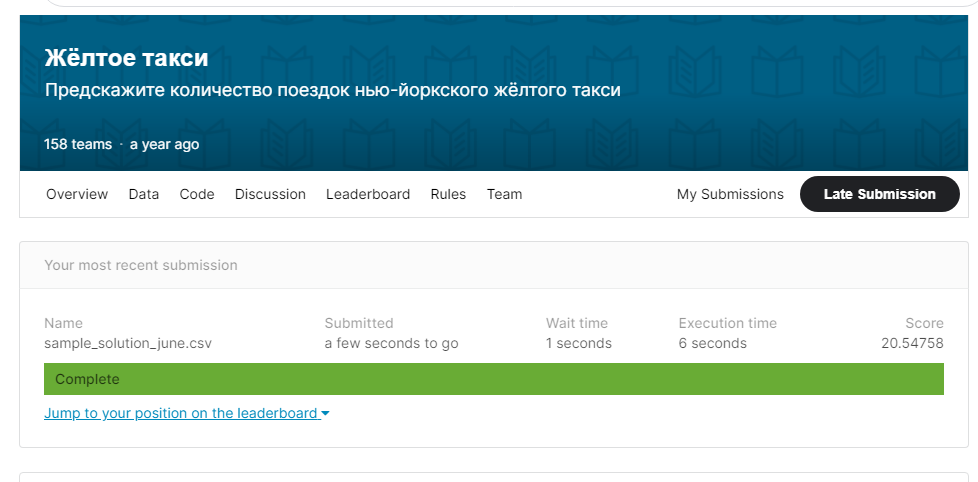

## 20.54 Отличный результат